In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import geocoder
from geopy.geocoders import Nominatim
import unittest
#!conda install -c conda-forge folium=0.5.0 --yes # Library for Map - Folium
import folium
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import re
from sklearn.cluster import KMeans 
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.linear_model import LinearRegression

# Scraping suburb information

### Scrape information about each Sydney suburb from Wikipedia

Here I use [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape the suburbs from Sydney as listed on [wikipedia](https://en.wikipedia.org/wiki/List_of_Sydney_suburbs). For each suburb, I identify the wikipage url for the indexed suburb, request access to the webpage, and then collect the following from their information box:
* **Postcode**: Postcode
* **Density**: Population density
* **Area**: Area size of suburb
* **LGA**: Local government assocation (council)
* **Location**: Distance from the city

In [2]:
with open("view-source_https___en.wikipedia.org_wiki_List_of_Sydney_suburbs.html") as html_file:
    soup = BeautifulSoup(html_file, "lxml")

syd_suburbs_section = soup.find('div',attrs={'class':'mw-parser-output'})
syd_suburbs_section = syd_suburbs_section.findAll('a', href=True)

In [3]:
# Scrape url for each suburb
def get_wiki_urls(html_suburbs_section, wiki_link_extension, wiki_state_name, state):
    url_list = {}
    for i in range(len(html_suburbs_section)):
        url = html_suburbs_section[i]['href']
        if wiki_link_extension in url:

            if any(x in url for x in ['File:', 'List_of_']):
                continue        

            else:
                suburb = html_suburbs_section[i]['title'].replace(wiki_state_name,'')

                if suburb in url_list:
                    continue           

                else:
                    url_list[suburb] = 'https://en.wikipedia.org{}'.format(url)
        
        # Sydney cbd
        elif '{}_CBD'.format(state) in url:
            suburb = html_suburbs_section[i]['title'] 
            url_list[suburb] = 'https://en.wikipedia.org{}'.format(url)

        # Brisbane cbd
        elif '{}_central_business_district'.format(state) in url:
            suburb = html_suburbs_section[i]['title']
            url_list[suburb] = 'https://en.wikipedia.org{}'.format(url)
        else:
            continue
    
    return url_list

In [4]:
wiki_state_name = ', New South Wales'
wiki_link_extension = ',_New_South_Wales'
state = 'Sydney'
syd_wiki_urls = get_wiki_urls(syd_suburbs_section, wiki_link_extension, wiki_state_name, state)
#syd_wiki_urls

In [5]:
# Scrape information box for each suburb from their wikipage.
# If an information box doesn't exist a try/catch error for the AttributeError will pass it.

def get_suburb_wiki_infobox(wiki_urls):
    
    suburbs_infobox = {}
    for key,value in wiki_urls.items():

        try:
            page = requests.get(value)
            soup_page = BeautifulSoup(page.text, 'html.parser')
            infobox = soup_page.find('table', class_='infobox vcard')
            suburbs_infobox[key] = infobox.find_all('tr', class_='')

        except AttributeError:
            suburbs_infobox[key] = None
            #print("{}'s wikipage does not have an information box".format(key))
            pass
    
    return suburbs_infobox

In [6]:
syd_suburb_infobox = get_suburb_wiki_infobox(syd_wiki_urls)

In [7]:
def get_suburb_info(suburb_infobox):
    CHECK_STRINGS = ('Density', 'Postcode', 'Area', 'Location')

    suburbs = {}

    for key,value in suburb_infobox.items():

        try:
            infobox_val = value
            items = {}

            for val in infobox_val:        

                if any(s in val.text for s in CHECK_STRINGS):
                    # Find check_strings in infobox list of strings
                    keyword = [s for s in CHECK_STRINGS if s in val.text]
                    keyword = keyword[0]

                    infobox_split = val.text.split(' ')
                    #infobox_split = re.split('  |\ ', val.text)

                    if len(infobox_split) > 1:
                        infobox_item = [s for s in infobox_split if str(keyword) in s]
                        # Remove substrings from string
                        info = infobox_item[0]
                        info = info.replace("Density","").replace('/km2',' ').replace(',','')\
                                   .replace("Area","").replace('\xa0km2',' ').replace(',','')\
                                   .replace("Location","").replace('\xa0km',' ').replace(',','')

                        info = info.split('\xa0(')
                        info = info[0]

                        # Convert Area, Density, and Location columns from string to numeric
                        try:
                            info = float(info)
                            items[keyword] = info
                        except:
                            info = None 
                            items[keyword] = info

                    elif len(infobox_split) == 1:
                        info = infobox_split[0]
                        info = info.replace("Postcode(s)","")
                        info = info.split('[')
                        info = info[0]
                        items[keyword] = info

                elif 'LGA' in val.text:
                    info = val.text.replace("LGA(s)","").replace(";",")")
                    info = info.split('[')
                    info = info[0]
                    items['LGA'] = info

                else:
                    continue

            suburbs[key] = items

        except TypeError:
            suburbs[key] = None
    
    return suburbs

In [8]:
sydney_suburbs = get_suburb_info(syd_suburb_infobox)

In [9]:
# Convert Sydney suburbs nested dictionary to a dataframe
sydney_suburbs_df = pd.DataFrame(sydney_suburbs).T
sydney_suburbs_df['Suburb'] = sydney_suburbs_df.index
sydney_suburbs_df.index = range(sydney_suburbs_df.shape[0])

sydney_suburbs_df.head(10)

,Area,Density,LGA,Location,Postcode,Suburb
0,NaN,NaN,Canterbury-Bankstown Council,16,2200,Bankstown
1,1.22,9550,Waverley Council,7,2026,Bondi Beach
2,2.8,6160,City of Sydney,NaN,2000,Sydney central business district
3,2.9,8590,City of Willoughby,10,2067,Chatswood
4,NaN,NaN,Sutherland Shire,26,2230,Cronulla
5,6.3,4300,City of Liverpool,27,2170,Liverpool
6,5.6,2833,Northern Beaches Council,17,2095,Manly
7,0.2,10800,North Sydney Council,3,2061,Milsons Point
8,8.7,3273,Mosman Council,8,2088,Mosman
9,1.6,9390,City of Sydney Inner West Council,4,2042,Newtown


Find and replace cells where the Area, Density, or Location is 0 to a nan. These values can be extrapolated later if necessary from their location and area data by regression modelling.

In [64]:
#sydney_suburbs_df.loc[sydney_suburbs_df['Area'] == 0.0]
#sydney_suburbs_df.loc[sydney_suburbs_df['Density'] == 0]
#sydney_suburbs_df.loc[sydney_suburbs_df['Location'] == 0]

Sydney suburb dataframe grouped according to the postcodes.

In [10]:
syd_suburbs_grouped = sydney_suburbs_df.groupby(["Postcode"]).agg({'Suburb':', '.join,\
                                                                         'Area': lambda x: x.mean(skipna=True),\
                                                                         'Density': lambda x: x.mean(skipna=True),\
                                                                         'Location': lambda x: x.mean(skipna=True)}).reset_index()
syd_suburbs_grouped = syd_suburbs_grouped.assign(State='NSW')
syd_suburbs_grouped.head(10)
#Convert density column from float to int

,Postcode,Suburb,Area,Density,Location,State
0,2000,"Sydney central business district, The Rocks, B...",1.002857,6005.571429,1.0,NSW
1,2007,Ultimo,0.600000,14700.000000,2.0,NSW
2,2008,"Chippendale, Darlington",0.600000,8393.000000,2.5,NSW
3,2009,Pyrmont,1.000000,13000.000000,2.0,NSW
4,2010,"Darlinghurst, Surry Hills",1.000000,12585.000000,1.0,NSW
5,2011,"Elizabeth Bay, Potts Point, Rushcutters Bay, W...",0.425000,12748.325000,2.5,NSW
6,2015,"Alexandria, Beaconsfield, Eveleigh",2.000000,2442.500000,4.0,NSW
7,2016,Redfern,1.200000,11000.000000,3.0,NSW
8,2017,"Waterloo, Zetland",0.950000,12950.000000,3.5,NSW
9,2018,"Eastlakes, Rosebery",1.350000,6254.750000,7.0,NSW



### Scrape information about each Brisbane suburb from Wikipedia

In [11]:
with open("view-source_https___en.wikipedia.org_wiki_List_of_Brisbane_suburbs.html") as html_file:
    soup = BeautifulSoup(html_file, "lxml")

bri_suburbs_section = soup.find('div',attrs={'id':'mw-content-text', 'class':'mw-content-ltr'})
bri_suburbs_section = bri_suburbs_section.find_all('a', href=True)

In [12]:
wiki_state_name = ', Queensland'
wiki_link_extension = ',_Queensland'
state = 'Brisbane'
bne_wiki_urls = get_wiki_urls(bri_suburbs_section, wiki_link_extension, wiki_state_name, state)

In [13]:
bne_suburb_infobox = get_suburb_wiki_infobox(bne_wiki_urls)

In [14]:
brisbane_suburbs = get_suburb_info(bne_suburb_infobox)

In [15]:
# Convert Brisbane suburbs nested dictionary to a dataframe
brisbane_suburbs_df = pd.DataFrame(brisbane_suburbs).T
brisbane_suburbs_df['Suburb'] = brisbane_suburbs_df.index
brisbane_suburbs_df.index = range(brisbane_suburbs_df.shape[0])

brisbane_suburbs_df.head(10)

,Area,Density,LGA,Location,Postcode,Suburb
0,2.07,4570,City of Brisbane(Central Ward),NaN,4000,Brisbane central business district
1,1.7,1900,City of Brisbane(Central Ward),NaN,4006,Bowen Hills
2,2,3000,City of Brisbane (The Gabba Ward),2.5,4169,East Brisbane
3,1.4,4980,City of Brisbane(Central Ward),1,4006,Fortitude Valley
4,1.7,1300,City of Brisbane(Central Ward),3,4006,Herston
5,1.2,5160,City of Brisbane (The Gabba Ward),2,4101,Highgate Hill
6,1.3,6200,City of Brisbane (The Gabba Ward),NaN,4169,Kangaroo Point
7,NaN,NaN,City of Brisbane(Paddington Ward),NaN,4059,Kelvin Grove
8,2,6300,City of Brisbane(Central Ward),2,4005,New Farm
9,1.3,1690,City of Brisbane(Central Ward),3,4006,Newstead


Find and replace cells where the Area, Density, or Location is 0 to a nan. These values can be extrapolated later if necessary from their location and area data by regression modelling.

In [16]:
#brisbane_suburbs_df.loc[brisbane_suburbs_df['Area'] == 0.0]
#brisbane_suburbs_df.loc[brisbane_suburbs_df['Density'] == 0.0]
#brisbane_suburbs_df.loc[brisbane_suburbs_df['Location'] == 0.0]
brisbane_suburbs_df['Density'] = brisbane_suburbs_df['Density'].replace(0, np.nan)

Check the density values for Mount Coot-tha and Spring Mountain have changed. Should be NaN.

In [17]:
brisbane_suburbs_df.loc[brisbane_suburbs_df['Suburb'].isin(['Mount Coot-tha','Spring Mountain'])]

,Area,Density,LGA,Location,Postcode,Suburb
169,16.6,NaN,City of Brisbane(Toowong Ward),NaN,4066,Mount Coot-tha
251,19.1,NaN,City of Ipswich,None,4124,Spring Mountain


Brisbane suburb dataframe grouped according to their postcodes.

In [18]:
bne_suburbs_grouped = brisbane_suburbs_df.groupby(["Postcode"]).agg({'Suburb':', '.join,\
                                                                         'Area': lambda x: x.mean(skipna=True),\
                                                                         'Density': lambda x: x.mean(skipna=True),\
                                                                         'Location': lambda x: x.mean(skipna=True)}).reset_index()
bne_suburbs_grouped = bne_suburbs_grouped.assign(State='QLD')
bne_suburbs_grouped.head(10)
#Convert density column from float to int

,Postcode,Suburb,Area,Density,Location,State
0,4000,"Brisbane central business district, Petrie Ter...",1.635,4775.0,2.000000,QLD
1,4005,"New Farm, Teneriffe",1.500,5820.0,2.250000,QLD
2,4006,"Bowen Hills, Fortitude Valley, Herston, Newstead",1.525,2467.5,2.333333,QLD
3,4007,"Ascot, Hamilton",2.200,3125.0,7.500000,QLD
4,4008,Pinkenba,NaN,NaN,9.000000,QLD
5,4009,Eagle Farm,NaN,NaN,9.000000,QLD
6,4010,Albion,1.400,1640.0,6.000000,QLD
7,4011,"Clayfield, Hendra",2.800,2675.0,8.000000,QLD
8,4012,"Nundah, Wavell Heights",4.100,2737.5,11.900000,QLD
9,4013,Northgate,3.100,1388.0,NaN,QLD


# Get geographical coordinates for each suburb

In [19]:
def get_latlong(df_pc, state):
    geolocator = Nominatim(user_agent="specify_your_app_name_here", timeout=3)
    
    lat = []
    long = []

    for index,row in df_pc.iterrows():
        postcode = row.Postcode
        location = geolocator.geocode("{} {} Australia".format(postcode, state))
        lat.append(location.latitude)
        long.append(location.longitude)

    latlong = dict({'lat':lat, 'long':long})
    latlong_df = pd.DataFrame(latlong)
    
    return latlong_df

In [20]:
# Geospatial coordinates for Sydney suburbs
latlong_syd = get_latlong(syd_suburbs_grouped, 'New South Wales')

In [21]:
# Geospatial coordinates for Brisbane suburbs
latlong_bne = get_latlong(bne_suburbs_grouped, 'Queensland')

### Merge the latlong dataframe with the suburbs_pc dataframe

In [22]:
syd_suburbs_coord = pd.concat([syd_suburbs_grouped, latlong_syd], axis=1)
bne_suburbs_coord = pd.concat([bne_suburbs_grouped, latlong_bne], axis=1)

# Plotting Sydney and Brisbane suburbs on maps

### Plotting Sydney suburb map

In [23]:
address = "Sydney, New South Wales"
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sydney, NSW are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sydney, NSW are -33.8548157, 151.2164539.


In [24]:
# create map of Toronto using latitude and longitude values
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=9.5)
# add markers to map
for lat, lng, postcode, suburb in zip(syd_suburbs_coord['lat'],\
                                      syd_suburbs_coord['long'],\
                                      syd_suburbs_coord['Postcode'],\
                                      syd_suburbs_coord['Suburb']):
    #print(lat, lng)
    label = '{}: {}'.format(postcode, suburb)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)  
    
map_sydney

### Plotting Brisbane suburb map

In [25]:
address = "Brisbane, Queensland"
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brisbane, Queensland are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brisbane, Queensland are -27.4689682, 153.0234991.


In [26]:
# create map of Toronto using latitude and longitude values
map_brisbane = folium.Map(location=[latitude, longitude], zoom_start=9.5)
# add markers to map
for lat, lng, postcode, suburb in zip(bne_suburbs_coord['lat'],\
                                      bne_suburbs_coord['long'],\
                                      bne_suburbs_coord['Postcode'],\
                                      bne_suburbs_coord['Suburb']):
    #print(lat, lng)
    label = '{}: {}'.format(postcode, suburb)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brisbane)  
    
map_brisbane

# Search for local venues in Sydney and Brisbane suburbs with Foursquare API

### Define Foursquare credentials and version

In [27]:
CLIENT_ID = 'JVA5H5NJXBQTUPSMHXXD0V0NKNP0OVJO0GKU1WJGLER5Q0DU' # Foursquare ID
CLIENT_SECRET = 'DMZV42OBBRZNSPQSGEUD3PE3N5EHUKRZYRTMSCLSORKPAO2W' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JVA5H5NJXBQTUPSMHXXD0V0NKNP0OVJO0GKU1WJGLER5Q0DU
CLIENT_SECRET:DMZV42OBBRZNSPQSGEUD3PE3N5EHUKRZYRTMSCLSORKPAO2W


# Explore suburbs of Sydney

In [28]:
suburbs_coord = pd.concat([syd_suburbs_coord, bne_suburbs_coord], axis=0)
suburbs_coord.shape

(358, 8)

Function that finds top 100 venues within 500m radius of the neighbourhood

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Here, I use the function to create a new dataframe that includes the venues.

In [30]:
top_venues = getNearbyVenues(names=suburbs_coord['Suburb'],
                             latitudes=suburbs_coord['lat'],
                             longitudes=suburbs_coord['long'])

Check size of dataframe

In [31]:
print(top_venues.shape)
top_venues.head(5)

(4025, 7)


,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,The Baxter Inn,-33.869707,151.205467,Whisky Bar
1,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,State Theatre,-33.871291,151.207049,Theater
2,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,Queen Victoria Building (QVB),-33.871521,151.206741,Shopping Mall
3,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,Uniqlo,-33.869744,151.208319,Clothing Store
4,"Sydney central business district, The Rocks, B...",-33.869938,151.207212,Haigh's Chocolates,-33.869207,151.207129,Candy Store


The number of unique categories that can be curated from all of the returned venues

In [32]:
print('There are {} uniques categories.'.format(len(top_venues['Venue Category'].unique())))

There are 288 uniques categories.


# Analysing each Suburb in Sydney and Brisbane

Here our aim is to show which suburbs in Brisbane are the most similar to a selected suburb in Sydney. To do this we will cluster Brisbane suburbs according to their top venues. Each cluster will share similarities in their top suburbs. Therefore it is ideal to have every suburb associated with a cluster even it is remotely similar. To do this we shall perform a hard-clustering technique such as 'K-means clustering'. Once we have grouped Brisbane suburbs into clusters, we will determine which of these groups are most similar to each suburb in Sydney. This will be done performing a classification k-nearest neighbour on the selected Sydney suburb with the Brisbane suburb clusters. Therefore, the clustered points that are nearest to the Sydney suburb will be the identified as the Brisbane suburbs that are most similar to the Sydney suburb.

In [33]:
# one hot encoding
top_venues_onehot = pd.get_dummies(top_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
top_venues_onehot['Suburb'] = top_venues['Suburb'] 

# move neighborhood column to the first column
fixed_columns = [top_venues_onehot.columns[-1]] + list(top_venues_onehot.columns[:-1])
top_venues_onehot = top_venues_onehot[fixed_columns]

top_venues_onehot.head()

,Suburb,Advertising Agency,Airport,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Sydney central business district, The Rocks, B...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examine the shape of the dataframe size

In [34]:
top_venues_onehot.shape

(4025, 289)

Group suburbs and calculate the mean of the frequency of occurance for each category

In [35]:
top_venues_grouped = top_venues_onehot.groupby('Suburb').mean().reset_index()
top_venues_grouped

,Suburb,Advertising Agency,Airport,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,"Abbotsbury, Bossley Park, Edensor Park, Greenf...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
1,"Abbotsford, Canada Bay, Chiswick, Five Dock, R...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
2,"Acacia Gardens, Quakers Hill",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
3,"Acacia Ridge, Heathwood, Larapinta, Pallara, W...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
4,Albion,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
5,"Alderley, Gaythorne, Grange, Newmarket, Wilsto...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
6,"Alexandria, Beaconsfield, Eveleigh",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
7,"Alfords Point, Bangor, Barden Ridge, Illawong,...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.250000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
8,"Algester, Parkinson",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0
9,"Allambie Heights, Beacon Hill, Brookvale, Nort...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0


In [36]:
top_venues_grouped.shape

(313, 289)

Some suburbs were not returned because those suburbs didn't have 10 venues within 500m listed on Foursquare.


Function that sorts most frequent venues in descending order

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating a new dataframe and display the top 10 venues for each neighbourhood

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_venues_sorted = pd.DataFrame(columns=columns)
top_venues_sorted['Suburb'] = top_venues_grouped['Suburb']

for ind in np.arange(top_venues_grouped.shape[0]):
    top_venues_sorted.iloc[ind, 1:] = return_most_common_venues(top_venues_grouped.iloc[ind, :], num_top_venues)

top_venues_sorted.head(5)

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbotsbury, Bossley Park, Edensor Park, Greenf...",Chinese Restaurant,Grocery Store,Café,Pub,Dessert Shop,Filipino Restaurant,Fried Chicken Joint,French Restaurant,Fountain,Forest
1,"Abbotsford, Canada Bay, Chiswick, Five Dock, R...",Gym,Grocery Store,Bus Station,Park,Mediterranean Restaurant,Café,Convenience Store,Martial Arts Dojo,Flea Market,Filipino Restaurant
2,"Acacia Gardens, Quakers Hill",Fast Food Restaurant,Snack Place,Baseball Field,Gas Station,Pizza Place,Convenience Store,Sandwich Place,Filipino Restaurant,Fish & Chips Shop,Fish Market
3,"Acacia Ridge, Heathwood, Larapinta, Pallara, W...",Furniture / Home Store,Yoga Studio,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
4,Albion,Café,Indian Restaurant,Turkish Restaurant,Fast Food Restaurant,Comedy Club,Sandwich Place,Seafood Restaurant,Thai Restaurant,Bakery,Train Station


Function to find Suburb and have a look at their top venues

In [39]:
def suburb_top_venues(venues_sorted, suburb_of_interset):
    return venues_sorted[venues_sorted['Suburb'].str.contains(suburb_of_interset)]

suburb_top_venues(top_venues_sorted, 'Randwick')

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
117,"Clovelly, Randwick",Café,Thai Restaurant,Burger Joint,Dessert Shop,Hotel,Pub,Supermarket,Gym,Fast Food Restaurant,Tapas Restaurant


# Cluster Brisbane Suburbs

In [40]:
# Split data from NSW to QLD
search_values = syd_suburbs_coord['Suburb'].values
syd_section = top_venues_grouped[top_venues_grouped.Suburb.str.contains('|'.join(search_values ))]
syd_section.index = pd.RangeIndex(len(syd_section.index))

In [41]:
syd_section.shape

(206, 289)

In [42]:
search_values = bne_suburbs_coord['Suburb'].values
bne_section = top_venues_grouped[top_venues_grouped.Suburb.str.contains('|'.join(search_values ))]
bne_section.index = pd.RangeIndex(len(bne_section.index))

/Users/Jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [43]:
bne_section

,Suburb,Advertising Agency,Airport,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,"Acacia Ridge, Heathwood, Larapinta, Pallara, W...",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
1,Albion,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
2,"Alderley, Gaythorne, Grange, Newmarket, Wilsto...",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
3,"Algester, Parkinson",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
4,"Amity Point, Dunwich, Point Lookout",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
5,"Annerley, Fairfield",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
6,"Anstead, Bellbowrie, Moggill",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
7,"Archerfield, Coopers Plains",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
8,"Ascot, Hamilton",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
9,Ashgrove,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0


Check shape of dataframe

In [44]:
print(syd_section.shape)
print(bne_section.shape)
print(top_venues_grouped.shape)

(206, 289)
(108, 289)
(313, 289)


Perform Cluster analysis with Brisbane suburbs

In [45]:
# Drop suburb column for cluster analysis
bne_venues_matrix_values = bne_section.drop('Suburb', 1)

Function that calculates euclidean distances for all points to their assigned cluster centroid.

In [46]:
def k_mean_distance(data, cantroid_matrix, i_centroid, cluster_labels):
    distances = [np.linalg.norm(x-cantroid_matrix) for x in data[cluster_labels == i_centroid]]
    return np.mean(distances)

In [47]:
k_optimisation = {}
nclusters = 20
clustering_matrix = bne_venues_matrix_values.values

for k in range(nclusters):
    k_means = KMeans(init = "k-means++", n_clusters = k+1, n_init = 100, random_state=10)
    k_means.fit(bne_venues_matrix_values)

    k_means_labels = k_means.labels_
    k_means_cluster_centers = k_means.cluster_centers_

    c_mean_distances = []
    for i, cent_features in enumerate(k_means_cluster_centers):
                mean_distance = k_mean_distance(clustering_matrix, cent_features, i, k_means_labels)
                c_mean_distances.append(mean_distance)

    k_optimisation[k+1] = np.mean(c_mean_distances)

Plot mean distances against number of k's

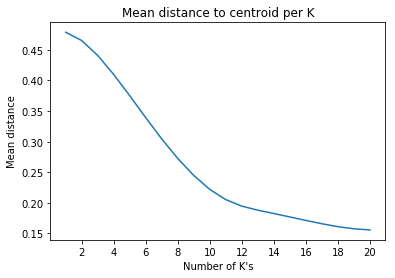

In [48]:
# sorted by key, return a list of tuples
lists = sorted(k_optimisation.items())
# unpack a list of pairs into two tuples
x, y = zip(*lists)
# Smooth data
ysmoothed = gaussian_filter1d(y, sigma=2)

x_ticks = x[1::2]
plt.plot(x, ysmoothed)
plt.xticks(x[1::2])
plt.xlabel('''Number of K's''')
plt.ylabel('Mean distance')
plt.title('Mean distance to centroid per K')
plt.show()

The inflexion point on the graph is approximately at 11. Therefore we will use 11 as our K value.

In [49]:
kclusters = 11
k_means = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 100, random_state=10)
k_means.fit(bne_venues_matrix_values)

k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

In [50]:
k_means_labels

array([ 0,  1,  1,  1,  2,  1,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  9,  1,  1,  9,  1,  1,  1,  5,  9,  1,  1,  1,  1,  1,  8,  1,
        9, 10,  1,  1,  1,  1,  2,  3,  9,  1, 10,  1,  1,  9,  1,  1,  1,
        1,  1,  1,  1,  5,  1,  2,  1,  6,  9,  1,  2,  1,  1,  9,  2,  1,
        1,  2,  1,  1,  1,  8,  9,  1,  9,  1,  1,  9,  1,  1,  1,  1,  1,
        8,  1,  2,  8,  1,  1,  1,  4,  7,  1,  9,  1,  1,  1,  9,  1,  1,
        1,  9,  1,  1,  1,  1], dtype=int32)

Add cluster labels

In [51]:
# add clustering labels
search_values = bne_section['Suburb'].values
bne_venues_sorted = top_venues_sorted[top_venues_sorted.Suburb.str.contains('|'.join(search_values ))]

bne_suburbs_coord_update = bne_suburbs_coord[bne_suburbs_coord.Suburb.str.contains('|'.join(search_values ))]


bne_venues_sorted.insert(0, 'Cluster Labels', k_means_labels)
bne_merged = bne_suburbs_coord_update

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bne_merged = bne_merged.join(bne_venues_sorted.set_index('Suburb'), on='Suburb')
bne_merged.index = pd.RangeIndex(len(bne_merged.index))
bne_merged.head(10) # check the last columns!

,Postcode,Suburb,Area,Density,Location,State,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4000,"Brisbane central business district, Petrie Ter...",1.635,4775.0,2.000000,QLD,-27.467224,153.027740,1,Café,Burger Joint,Bar,Coffee Shop,Hotel,Japanese Restaurant,Sushi Restaurant,Restaurant,Italian Restaurant,Plaza
1,4005,"New Farm, Teneriffe",1.500,5820.0,2.250000,QLD,-27.464018,153.045491,1,Café,Italian Restaurant,Indian Restaurant,BBQ Joint,Deli / Bodega,Coffee Shop,Cocktail Bar,Shopping Mall,Burger Joint,Supermarket
2,4006,"Bowen Hills, Fortitude Valley, Herston, Newstead",1.525,2467.5,2.333333,QLD,-27.459367,153.038752,1,Coffee Shop,Japanese Restaurant,Bar,Pub,Cocktail Bar,Café,Beer Bar,Burger Joint,Asian Restaurant,Pizza Place
3,4007,"Ascot, Hamilton",2.200,3125.0,7.500000,QLD,-27.433788,153.063037,1,Café,Burger Joint,Japanese Restaurant,Sandwich Place,Flea Market,Bakery,Noodle House,Grocery Store,Thai Restaurant,Italian Restaurant
4,4008,Pinkenba,NaN,NaN,9.000000,QLD,-27.374745,153.122608,4,Airport Terminal,Zoo Exhibit,Food Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Football Stadium
5,4009,Eagle Farm,NaN,NaN,9.000000,QLD,-27.432873,153.090375,1,Go Kart Track,Diner,Zoo Exhibit,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
6,4010,Albion,1.400,1640.0,6.000000,QLD,-27.430104,153.042181,1,Café,Indian Restaurant,Turkish Restaurant,Fast Food Restaurant,Comedy Club,Sandwich Place,Seafood Restaurant,Thai Restaurant,Bakery,Train Station
7,4011,"Clayfield, Hendra",2.800,2675.0,8.000000,QLD,-27.427707,153.046410,1,Sushi Restaurant,Indian Restaurant,Convenience Store,Bus Station,Breakfast Spot,Café,Seafood Restaurant,Thai Restaurant,Bakery,Fast Food Restaurant
8,4012,"Nundah, Wavell Heights",4.100,2737.5,11.900000,QLD,-27.393142,153.048584,1,Café,Liquor Store,Bakery,Pizza Place,Home Service,Food Court,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
9,4013,Northgate,3.100,1388.0,NaN,QLD,-27.391140,153.069953,8,Brewery,Gym,Garden,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service


Plot clusters onto map

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, suburb, cluster in zip(bne_merged['lat'], bne_merged['long'], bne_merged['Suburb'], bne_merged['Cluster Labels']):
    label = folium.Popup(str(suburb) + ': Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Here the suburbs are clustered according to their top venues. Therefore suburbs that are north of Brisbane such as Burpengary (cluster 1) would be similar to suburbs close to the city such as East Brisbane and Kangaroo Point.
Although the suburbs are similar in regards to the local venues, they are vastly different in population density, area, and distance from the cbd. For example the Burpengary the population density is These attributes should also be taken into consideration when buyers from Sydney are looking for a home in Brisbane.
These attributes were conveniently scraped earlier from Wikipedia.

### Data wrangling for regression modelling

In [55]:
bne_area = bne_merged['Area'].values
bne_density = bne_merged['Density'].values
bne_distance = bne_merged['Location'].values

In [56]:
print('''Area has {} nan's'''.format(np.count_nonzero(np.isnan(bne_area))))
print('')
print('''Density has {} nan's'''.format(np.count_nonzero(np.isnan(bne_density))))
print('')
print('''Distance has {} nan's'''.format(np.count_nonzero(np.isnan(bne_distance))))

Area has 28 nan's

Density has 29 nan's

Distance has 14 nan's


Inspect the rows with the missing values in the brisbane suburb dataframe.

In [57]:
# Show rows that have a NaN value
bne_merged[bne_merged.isnull().any(axis=1)]

,Postcode,Suburb,Area,Density,Location,State,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,4008,Pinkenba,NaN,NaN,9.000000,QLD,-27.374745,153.122608,4,Airport Terminal,Zoo Exhibit,Food Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Football Stadium
5,4009,Eagle Farm,NaN,NaN,9.000000,QLD,-27.432873,153.090375,1,Go Kart Track,Diner,Zoo Exhibit,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
9,4013,Northgate,3.10,1388.00,NaN,QLD,-27.391140,153.069953,8,Brewery,Gym,Garden,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service
11,4018,"Fitzgibbon, Taigum",NaN,NaN,14.500000,QLD,-27.342192,153.038350,1,Supermarket,Shopping Mall,Playground,Zoo Exhibit,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
12,4019,"Clontarf, Margate, Woody Point",6.30,1314.00,NaN,QLD,-27.256934,153.096005,2,Park,Seafood Restaurant,Gas Station,Bowling Green,Bus Station,Food Court,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop
13,4020,"Newport, Redcliffe, Scarborough",NaN,NaN,28.000000,QLD,-27.221432,153.109551,2,Park,Business Service,Food Court,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Zoo Exhibit
14,4021,Kippa-Ring,NaN,NaN,NaN,QLD,-27.222065,153.086233,1,Café,Movie Theater,Donut Shop,Fried Chicken Joint,Supermarket,Mobile Phone Shop,Food Court,Auto Dealership,Fast Food Restaurant,Department Store
15,4022,Rothwell,10.10,709.00,NaN,QLD,-27.214952,153.057710,9,Carpet Store,Performing Arts Venue,Bus Station,Zoo Exhibit,Food & Drink Shop,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food Court
28,4061,The Gap,12.20,1368.00,NaN,QLD,-27.444412,152.943180,1,Museum,Grocery Store,Thai Restaurant,Trail,Bus Station,Convenience Store,Food & Drink Shop,Fish & Chips Shop,Fish Market,Flea Market
30,4065,Bardon,4.90,1939.00,NaN,QLD,-27.459950,152.981611,1,Gym,Supermarket,Playground,Zoo Exhibit,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop


Rows where all three attributes are NaN's should be removed from the dataframe since none of the values can be extrapolated from each other with regression modelling.

In [59]:
# Find rows where the area, density, and distance are all NaN's.
attributes_all_nan = bne_merged[bne_merged['Area'].isnull() & (bne_merged['Density'].isnull()) & (bne_merged['Location'].isnull())]

,Postcode,Suburb,Area,Density,Location,State,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,4021,Kippa-Ring,NaN,NaN,NaN,QLD,-27.222065,153.086233,1,Café,Movie Theater,Donut Shop,Fried Chicken Joint,Supermarket,Mobile Phone Shop,Food Court,Auto Dealership,Fast Food Restaurant,Department Store
96,4307,Mutdapilly,NaN,NaN,NaN,QLD,-27.812241,152.665056,1,Pub,Beer Garden,Café,Fried Chicken Joint,French Restaurant,Fountain,Forest,Football Stadium,Food Service,Fast Food Restaurant
97,4346,Marburg,NaN,NaN,NaN,QLD,-27.611014,153.072118,9,Bus Station,History Museum,Sandwich Place,Pizza Place,Café,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market
107,4512,"Bracalba, Wamuran Basin, Wamuran",NaN,NaN,NaN,QLD,-27.611014,153.072118,9,Bus Station,History Museum,Sandwich Place,Pizza Place,Café,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market


In [76]:
# Remove those rows where all three attributes are NaN's from the main datafram.
bne_reg_data = pd.concat([bne_merged, attributes_all_nan]).drop_duplicates(keep=False)

In [77]:
print(bne_merged.shape)
print(attributes_all_nan.shape)
print(bne_reg_data.shape)

(108, 19)
(4, 19)
(104, 19)


Re-check number of nan's for each attribute/column.

In [78]:
bne_area = bne_reg_data['Area'].values
bne_density = bne_reg_data['Density'].values
bne_distance = bne_reg_data['Location'].values

print('''Area has {} nan's'''.format(np.count_nonzero(np.isnan(bne_area))))
print('')
print('''Density has {} nan's'''.format(np.count_nonzero(np.isnan(bne_density))))
print('')
print('''Distance has {} nan's'''.format(np.count_nonzero(np.isnan(bne_distance))))

Area has 24 nan's

Density has 25 nan's

Distance has 10 nan's


### Check histograms of area, density, and distance to see if data needs to be transformed to obtain a normal distribution

Missing values for area, Population density, and distance from cbd will be interpolated from regression modelling. Here I hypothesize that suburbs further away from the cbd are both larger and have a smaller population density.

* Firstly, I need check their distributions by plotting the data onto histograms. Then I'll see if data needs to be transformed to obtain a normal distribution.
* Secondly, I will generate scatterplots to see if there's a correlation between area, population density, and distance.
* Assuming that there will be a correlation between area, population density, and distance, I will interpolate the missing values from the regression models.

Plot data as a histogram and find appropriate transformation method

/Users/Jason/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Jason/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


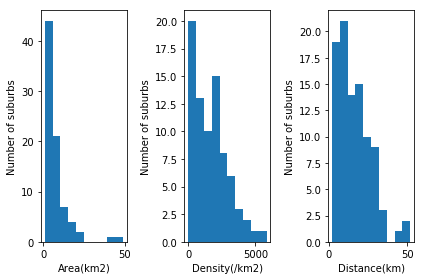

In [79]:
# Remove all nan's for histogram
bne_area_hist = bne_area[~np.isnan(bne_area)]
bne_density_hist = bne_density[~np.isnan(bne_density)]
bne_distance_hist = bne_distance[~np.isnan(bne_distance)]

plt.subplot(1, 3, 1)
plt.hist(bne_area)
plt.xlabel('Area(km2)')
plt.ylabel('Number of suburbs')

plt.subplot(1, 3, 2)
plt.hist(bne_density)
plt.xlabel('Density(/km2)')
plt.ylabel('Number of suburbs')

plt.subplot(1, 3, 3)
plt.hist(bne_distance)
plt.xlabel('Distance(km)')
plt.ylabel('Number of suburbs')

plt.tight_layout()
plt.show()

Transform data to a normal distribution using log or sqrt transformation. And plot data onto histograms.

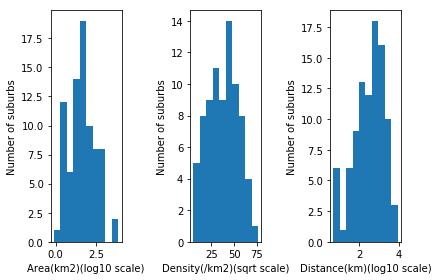

In [82]:
bne_area_transformed = np.log(bne_area)
bne_density_transformed = np.sqrt(bne_density)
bne_distance_transformed = np.log(bne_distance)

plt.subplot(131)
plt.hist(bne_area_transformed)
plt.xlabel('Area(km2)(log10 scale)')
plt.ylabel('Number of suburbs')

plt.subplot(132)
plt.hist(bne_density_transformed)
plt.xlabel('Density(/km2)(sqrt scale)')
plt.ylabel('Number of suburbs')

plt.subplot(133)
plt.hist(bne_distance_transformed)
plt.xlabel('Distance(km)(log10 scale)')
plt.ylabel('Number of suburbs')

plt.tight_layout()
plt.show()

### Create Linear regression models and generate scatter plots of the suburb attributes against each other and find their r^2 values.

Here I plot the suburb attributes (area, distance, and density) against each other and find the combinations that are the most suitable to interpolate the missing values. The most suitable combinations will be determined by their r^2 values.

Find the indexes where the values are NaN and remove from all three attributes.

In [85]:
reg_data = {'area':bne_area_transformed, 'density':bne_density_transformed, 'distance':bne_distance_transformed}
reg_df = pd.DataFrame.from_dict(reg_data)
reg_df.head(5)

,area,density,distance
0,0.491643,69.101375,0.693147
1,0.405465,76.288924,0.810930
2,0.421994,49.673937,0.847298
3,0.788457,55.901699,2.014903
4,NaN,NaN,2.197225


In [86]:
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [87]:
X = reg_df['area']
Y = reg_df['density']

In [93]:
lm.fit(X, Y)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.4916428   0.40546511  0.42199441  0.78845736         nan         nan
  0.33647224  1.02961942  1.41098697  1.13140211  1.39252491         nan
  1.84054963         nan  2.31253542  0.51082562  1.64865863  1.22377543
  1.54756251  2.55722731  2.22570405  1.08743899  1.35066718  1.5260563
  1.88706965  0.53062825  1.77495235  2.50143595  0.58778666  1.58923521
  2.20276476  1.22377543  1.29928298  2.48156775  2.30258509         nan
  0.58778666  0.74193734  3.0301337   1.66770682         nan  0.53062825
 -0.10536052  0.69314718  1.09861229  1.22377543  2.20827441  1.54756251
  1.48160454  1.5114575   2.1517622   1.74046617  1.5040774   2.05412373
         nan  1.28093385  2.04122033  1.77495235         nan         nan
  1.07840958  1.33500107  1.50961758  2.73241756  2.94968834         nan
         nan         nan  2.82731362         nan         nan         nan
  1.66770682  1.51512723  2.30258509         nan         nan  2.04122033
         nan         nan  1.80828877  2.46809953  3.08648664  0.50077529
  1.37792611  0.47000363  2.11625551         nan         nan  1.39871688
  1.75785792  3.77505715  1.75785792  2.70136121  1.06471074  2.18041746
  2.2300144   2.73436751  3.88773031         nan  2.69462718         nan
         nan  2.41591378].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
print('intercept: {}'.format(lm.intercept_))
print('coefficient: {}'.format(lm.coef_))

In [ ]:
plt.scatter(bne_distance_transformed, bne_density_transformed)
plt.show()

In [ ]:
# Add transformed columns onto dataframe

# Convert to dummy variables

# Perform cluster analysis again

# KNN classification with Sydney suburbs and Brisbane clustered data

In [ ]:
bne_merged.shape